<a href="https://colab.research.google.com/github/Darshan-20310597/Computer-Vision/blob/master/Copy_of_audio_preprocessing_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch>=1.2.0
!pip install torchaudio
%matplotlib inline

     |████████████████████████████████| 1.9MB 11.0MB/s 



torchaudio Tutorial
===================

PyTorch is an open source deep learning platform that provides a
seamless path from research prototyping to production deployment with
GPU support.

Significant effort in solving machine learning problems goes into data
preparation. torchaudio leverages PyTorch’s GPU support, and provides
many tools to make data loading easy and more readable. In this
tutorial, we will see how to load and preprocess data from a simple
dataset.

For this tutorial, please make sure the ``matplotlib`` package is
installed for easier visualization.




In [ ]:
import torch
import torchaudio
import matplotlib.pyplot as plt

Opening a dataset
-----------------




torchaudio supports loading sound files in the wav and mp3 format. We
call waveform the resulting raw audio signal.




Shape of waveform: torch.Size([2, 276858])
Sample rate of waveform: 44100


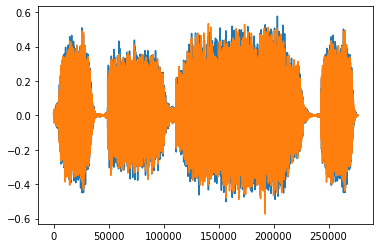

In [ ]:
import requests

url = "https://pytorch.org/tutorials//_static/img/steam-train-whistle-daniel_simon-converted-from-mp3.wav"
r = requests.get(url)

with open('steam-train-whistle-daniel_simon-converted-from-mp3.wav', 'wb') as f:
    f.write(r.content)

filename = "steam-train-whistle-daniel_simon-converted-from-mp3.wav"
waveform, sample_rate = torchaudio.load(filename)

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.figure()
plt.plot(waveform.t().numpy())

Transformations
---------------

torchaudio supports a growing list of
`transformations <https://pytorch.org/audio/transforms.html>`_.

-  **Resample**: Resample waveform to a different sample rate.
-  **Spectrogram**: Create a spectrogram from a waveform.
-  **MelScale**: This turns a normal STFT into a Mel-frequency STFT,
   using a conversion matrix.
-  **AmplitudeToDB**: This turns a spectrogram from the
   power/amplitude scale to the decibel scale.
-  **MFCC**: Create the Mel-frequency cepstrum coefficients from a
   waveform.
-  **MelSpectrogram**: Create MEL Spectrograms from a waveform using the
   STFT function in PyTorch.
-  **MuLawEncoding**: Encode waveform based on mu-law companding.
-  **MuLawDecoding**: Decode mu-law encoded waveform.

Since all transforms are nn.Modules or jit.ScriptModules, they can be
used as part of a neural network at any point.




To start, we can look at the log of the spectrogram on a log scale.




Shape of spectrogram: torch.Size([2, 201, 1385])


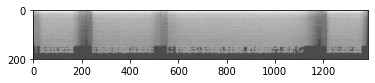

In [ ]:
specgram = torchaudio.transforms.Spectrogram()(waveform)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy(), cmap='gray')

Or we can look at the Mel Spectrogram on a log scale.




/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:358: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


Shape of spectrogram: torch.Size([2, 128, 1385])


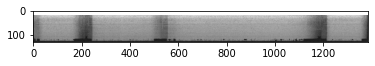

In [ ]:
specgram = torchaudio.transforms.MelSpectrogram()(waveform)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
p = plt.imshow(specgram.log2()[0,:,:].detach().numpy(), cmap='gray')

We can resample the waveform, one channel at a time.




Shape of transformed waveform: torch.Size([1, 27686])


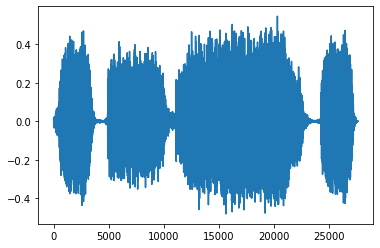

In [ ]:
new_sample_rate = sample_rate/10

# Since Resample applies to a single channel, we resample first channel here
channel = 0
transformed = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(waveform[channel,:].view(1,-1))

print("Shape of transformed waveform: {}".format(transformed.size()))

plt.figure()
plt.plot(transformed[0,:].numpy())

As another example of transformations, we can encode the signal based on
Mu-Law enconding. But to do so, we need the signal to be between -1 and
1. Since the tensor is just a regular PyTorch tensor, we can apply
standard operators on it.




In [ ]:
# Let's check if the tensor is in the interval [-1,1]
print("Min of waveform: {}\nMax of waveform: {}\nMean of waveform: {}".format(waveform.min(), waveform.max(), waveform.mean()))

Min of waveform: -0.572845458984375
Max of waveform: 0.575958251953125
Mean of waveform: 9.293758921558037e-05


Since the waveform is already between -1 and 1, we do not need to
normalize it.




In [ ]:
def normalize(tensor):
    # Subtract the mean, and scale to the interval [-1,1]
    tensor_minusmean = tensor - tensor.mean()
    return tensor_minusmean/tensor_minusmean.abs().max()

# Let's normalize to the full interval [-1,1]
# waveform = normalize(waveform)

Let’s apply encode the waveform.




Shape of transformed waveform: torch.Size([2, 276858])


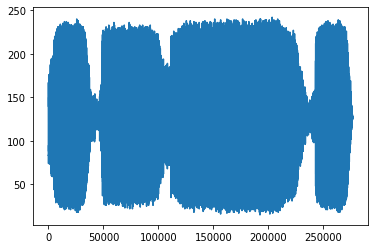

In [ ]:
transformed = torchaudio.transforms.MuLawEncoding()(waveform)

print("Shape of transformed waveform: {}".format(transformed.size()))

plt.figure()
plt.plot(transformed[0,:].numpy())

And now decode.




Shape of recovered waveform: torch.Size([2, 276858])


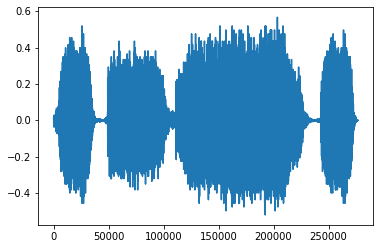

In [ ]:
reconstructed = torchaudio.transforms.MuLawDecoding()(transformed)

print("Shape of recovered waveform: {}".format(reconstructed.size()))

plt.figure()
plt.plot(reconstructed[0,:].numpy())

We can finally compare the original waveform with its reconstructed
version.




In [ ]:
# Compute median relative difference
err = ((waveform-reconstructed).abs() / waveform.abs()).median()

print("Median relative difference between original and MuLaw reconstucted signals: {:.2%}".format(err))

Median relative difference between original and MuLaw reconstucted signals: 1.28%


Migrating to torchaudio from Kaldi
----------------------------------

Users may be familiar with
`Kaldi <http://github.com/kaldi-asr/kaldi>`_, a toolkit for speech
recognition. torchaudio offers compatibility with it in
``torchaudio.kaldi_io``. It can indeed read from kaldi scp, or ark file
or streams with:

-  read_vec_int_ark
-  read_vec_flt_scp
-  read_vec_flt_arkfile/stream
-  read_mat_scp
-  read_mat_ark

torchaudio provides Kaldi-compatible transforms for ``spectrogram`` and
``fbank`` with the benefit of GPU support, see
`here <compliance.kaldi.html>`__ for more information.




Shape of spectrogram: torch.Size([1383, 201])


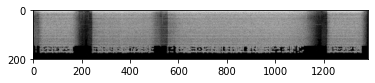

In [ ]:
n_fft = 400.0
frame_length = n_fft / sample_rate * 1000.0
frame_shift = frame_length / 2.0

params = {
    "channel": 0,
    "dither": 0.0,
    "window_type": "hanning",
    "frame_length": frame_length,
    "frame_shift": frame_shift,
    "remove_dc_offset": False,
    "round_to_power_of_two": False,
    "sample_frequency": sample_rate,
}

specgram = torchaudio.compliance.kaldi.spectrogram(waveform, **params)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
plt.imshow(specgram.t().numpy(), cmap='gray')

We also support computing the filterbank features from waveforms,
matching Kaldi’s implementation.




Shape of fbank: torch.Size([1383, 23])


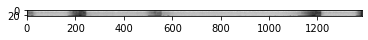

In [ ]:
fbank = torchaudio.compliance.kaldi.fbank(waveform, **params)

print("Shape of fbank: {}".format(fbank.size()))

plt.figure()
plt.imshow(fbank.t().numpy(), cmap='gray')

Conclusion
----------

We used an example raw audio signal, or waveform, to illustrate how to
open an audio file using torchaudio, and how to pre-process and
transform such waveform. Given that torchaudio is built on PyTorch,
these techniques can be used as building blocks for more advanced audio
applications, such as speech recognition, while leveraging GPUs.


